In [1]:
import xarray as xr
import os
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from scipy.stats import f
from sklearn.linear_model import LinearRegression, RidgeCV
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
from tqdm import tqdm
from plotnine import ggplot, aes, geom_line, geom_ribbon, scale_x_log10, scale_x_continuous, labs, theme, facet_wrap, ggsave
import seaborn as sns
from sklearn.metrics import r2_score
from matplotlib.widgets import Slider
from ipywidgets import interact, IntSlider, interactive
import ipywidgets as widgets
from IPython.display import display, clear_output
from ipywidgets import widgets, VBox
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from matplotlib.cm import get_cmap
from matplotlib.colors import Normalize
from scipy.linalg import null_space
from scipy.signal import detrend
import pandas as pd

from direct_effect_analysis import DirectEffectAnalysis

In [2]:
ds = xr.open_dataset("land_sea_mask.nc")
land_sea_mask = ds["land_sea_mask"]

# Loading data
* Selecting run

In [3]:
run = '1500'
folder = '../Dynamical_adjustment/data/' + run + '/'
psl_h = xr.open_dataset(folder + 'Z500_day_b.e212.BHISTcmip6.f09_g17.' + run + '.nc')
trefht_h = xr.open_dataset(folder + 'TREFHT_day_b.e212.BHISTcmip6.f09_g17.' + run + '.nc')
trefht_n = xr.open_dataset(folder + 'TREFHT_day_b.e212.B1850cmip6.f09_g17.001.nudge-1850-2100-SSP370.' + run + '.linear-weak.nc')

* Selecting years 1979-2015 (should add 2015-2023 with projection)

In [4]:
trefht_n = trefht_n.sel(time=trefht_n['time.year'].isin(np.arange(1979, 2015)))
trefht_h = trefht_h.sel(time=trefht_h['time.year'].isin(np.arange(1979, 2015)))
psl_h = psl_h.sel(time=psl_h['time.year'].isin(np.arange(1979, 2015)))

### Selecting summer months (and coarsening)
* We coarsen Z500 to avoid overfitting

In [5]:
c = 6 # Coarsening the atmospheric circulation to avoid overfitting
# Define summer months (June, July, August)
summer_months = [6, 7, 8]

# psl_recent: Seasonal anomaly and summer months selection
psl_recent = psl_h.sel(time=psl_h['time.month'].isin(summer_months)).coarsen(lat=c, lon=c, boundary='trim').mean()

# trefht_recent: Seasonal anomaly and summer months selection
trefht_recent = trefht_h.sel(time=trefht_h['time.month'].isin(summer_months)).sel(time=slice(psl_recent.time[0], psl_recent.time[-1])) \

# trefht_recent: Seasonal anomaly and summer months selection
trefht_nudge = trefht_n.sel(time=trefht_n['time.month'].isin(summer_months)).sel(time=slice(psl_recent.time[0], psl_recent.time[-1])) \


SyntaxError: unexpected EOF while parsing (2330315615.py, line 12)

* Removing seasonalities

In [ ]:
seasonality = psl_recent.groupby('time.month').mean()
psl_recent = (psl_recent.groupby('time.month') - seasonality)

seasonality = trefht_recent.groupby('time.month').mean()
trefht_recent = (trefht_recent.groupby('time.month') - seasonality)

seasonality = trefht_nudge.groupby('time.month').mean()
trefht_nudge = (trefht_nudge.groupby('time.month') - seasonality)

* Generating GMT with one month smoothing

In [ ]:
n_days = 1
# Compute GMST (Global Mean Surface Temperature)
gmst_recent = trefht_h.TREFHT.mean(dim=("lat", "lon"))
gmst_nudge = trefht_n.TREFHT.mean(dim=("lat", "lon"))

# Apply rolling mean (same as convolution with a uniform window)
gmst_recent_rolling = gmst_recent.rolling(time=n_days, center=True).mean().sel(time=trefht_h['time.month'].isin(summer_months))
gmst_nudge_rolling = gmst_nudge.rolling(time=n_days, center=True).mean().sel(time=trefht_h['time.month'].isin(summer_months))

gmst_recent = gmst_recent_rolling.data[:, None]
gmst_nudge = gmst_nudge_rolling.data[:, None]

In [ ]:
gmst_recent = gmst_recent - gmst_recent.mean()
gmst_nudge = gmst_nudge - gmst_nudge.mean()

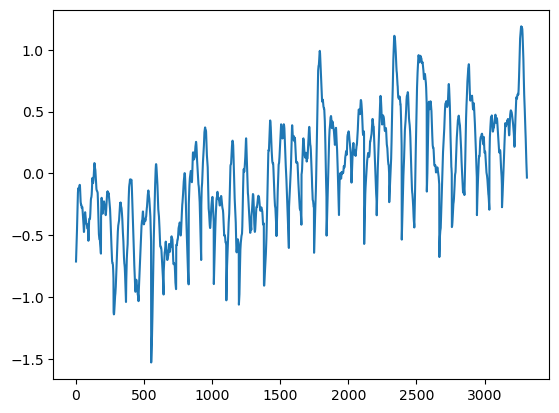

In [ ]:
plt.plot(gmst_recent)

* Selecting mid-latitudes

In [ ]:
trefht_recent = trefht_recent.sel(lat=slice(30, 70))
trefht_nudge = trefht_nudge.sel(lat=slice(30, 70))
psl_recent = psl_recent.sel(lat=slice(-10, 90))

* Useful data

In [ ]:
land_sea_mask_recent = land_sea_mask.interp_like(trefht_recent)

# Saving lat, lon and time
lats = trefht_recent.lat.data
lons = trefht_recent.lon.data
time = trefht_recent.time.data

psl_recent.Z500.shape, trefht_recent.TREFHT.shape, trefht_nudge.TREFHT.shape

((3312, 18, 48), (3312, 42, 288), (3312, 42, 288))

* Formatting data for model training

In [ ]:
# Converting xarray to numpy array
X = psl_recent.Z500.data - psl_recent.Z500.data.mean(axis=(1, 2))[:, None, None]
Y= trefht_recent.TREFHT.values
Y_counterfactual = trefht_nudge.TREFHT.values

# X, Y, Y_counterfactual = X[n_days:-n_days, :], Y[n_days:-n_days, :], Y_counterfactual[n_days:-n_days, :]

X_2d, Y_2d, Y_c_2d = X.reshape((X.shape[0], -1)), Y.reshape((X.shape[0], -1)), Y_counterfactual.reshape((Y_counterfactual.shape[0], -1))
X_train, X_test, Y_train, Y_test, Z_train, Z_test = train_test_split(X_2d, Y_2d, gmst_recent, test_size=0.2)

X_train.shape, Y_train.shape, Z_train.shape

((2649, 864), (2649, 12096), (2649, 1))

In [ ]:
n_cps = np.logspace(0.15, 2.2, 20).astype('int')
dea = DirectEffectAnalysis(n_components='optimal', n_cps=n_cps, k_fold=5)
dea.fit(X_train, Y_train, Z_train, fit_test=False)
dea.n_components_

100%|██████████| 20/20 [00:59<00:00,  2.97s/it]


158

In [ ]:
Y_dyn, Y_thermo = dea.counterfactual(Y_2d, gmst_nudge)
Y_rec = Y_dyn + Y_thermo

In [ ]:
ts_r2 = r2_score(Y_c_2d, Y_rec)
ts_corr = np.mean([np.corrcoef(Y_c_2d[:, i], Y_rec[:, i])[0, 1] for i in range(Y_rec.shape[1])])
ts_r2, ts_corr

(0.8557837605476379, 0.9290930579723794)

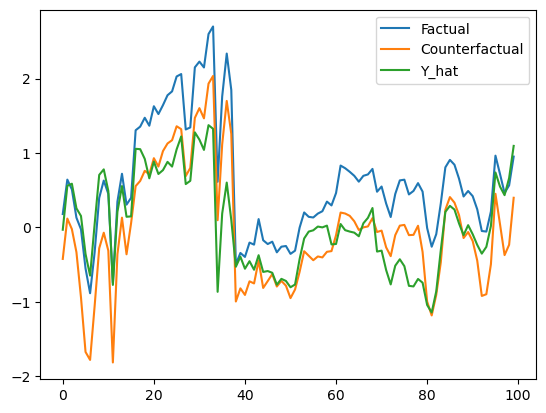

In [ ]:
idx = 100
samples = 100
plt.plot(Y_2d[-samples:, idx], label='Factual')
plt.plot(Y_c_2d[-samples:, idx], label='Counterfactual')
plt.plot(Y_rec[-samples:, idx], label='Y_hat')

plt.legend()
plt.show()

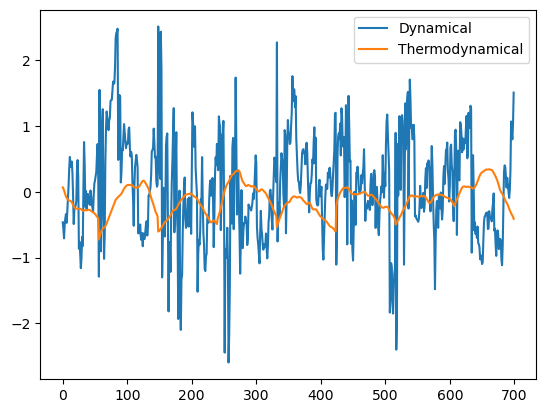

In [ ]:
idx = 100
samples = 700
plt.plot(Y_dyn[-samples:, idx], label='Dynamical')
plt.plot(Y_thermo[-samples:, idx], label='Thermodynamical')
plt.legend()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import Normalize
from matplotlib.cm import get_cmap

def plot_trends_on_world_map(errors, predicted_trends, true_trends, sign_errors_map, lats, lons, land_sea_mask, run):
    # Mask the land-sea areas for each map
    errors_masked = np.where(land_sea_mask, errors*920, np.nan)
    predicted_trends_masked = np.where(land_sea_mask, predicted_trends*920, np.nan)
    true_trends_masked = np.where(land_sea_mask, true_trends*920, np.nan)
    sign_masked = np.where(land_sea_mask, sign_errors_map, 0)

    # Create a colormap
    cmap = get_cmap('RdBu_r')

    # Find the maximum trend value for consistent normalization across all maps
    max_trend = np.max([np.nanmax(errors*920), np.nanmax(predicted_trends*920), np.nanmax(true_trends*920)])
    norm = Normalize(vmin=-max_trend, vmax=max_trend)

    # Create a figure with 3 subplots
    fig, axs = plt.subplots(3, 1, figsize=(18, 10), subplot_kw={'projection': ccrs.PlateCarree()})

    # List of maps and titles for each plot
    maps = [errors_masked, predicted_trends_masked, true_trends_masked]
    titles = ['Errors', 'Predicted Trends', 'True Trends']

    # Iterate over the maps and plot each one
    for i, ax in enumerate(axs):
        trend_map = maps[i]
        
        # Plot the trend map
        trend_plot = ax.pcolormesh(lons, lats, trend_map, transform=ccrs.PlateCarree(),
                                   cmap=cmap, norm=norm, shading='auto')

        # Overlay hatching on predicted trends plot (index 1)
        if i == 0:
            ax.contourf(lons, lats, sign_masked, levels=[0.5, 1.5], colors='none', hatches=['///'], transform=ccrs.PlateCarree())

        # Customize each subplot
        ax.coastlines()
        ax.add_feature(cfeature.LAND, facecolor='none', edgecolor='black')
        ax.add_feature(cfeature.BORDERS, linestyle=':')

        # Set titles for each subplot
        ax.set_title(titles[i], fontsize=14)

    # Add a colorbar and adjust its position to be lower
    cbar_ax = fig.add_axes([0.1, -0.05, 0.8, 0.03])  # Adjust the position (left, bottom, width, height)
    cbar = fig.colorbar(trend_plot, cax=cbar_ax, orientation='horizontal')
    cbar.set_label("Trend Value")
    plt.title(run)
    plt.tight_layout()
    plt.show()

### Computing trends 

In [ ]:
# trends for predicted nudge
trends = LinearRegression().fit(np.arange(Y_rec.shape[0])[:,None], Y_rec).coef_
trends_map = trends.reshape(Y.shape[1], Y.shape[2])

# trends for nudge 
Y_c_2d = Y_counterfactual.reshape((Y_counterfactual.shape[0], -1))
trends_counterfactual = LinearRegression().fit(np.arange(Y_c_2d.shape[0])[:,None], Y_c_2d).coef_
trends_map_counterfactual = trends_counterfactual.reshape((Y_counterfactual.shape[1], -1))

In [ ]:
sign_errors = np.abs(np.sign(trends) - np.sign(trends_counterfactual))/2
sign_errors_map = sign_errors.reshape((Y_counterfactual.shape[1], -1))
correct_sign_ratio = np.mean(sign_errors==0)

In [ ]:
trendsr2 = r2_score(trends_counterfactual, trends)
trends_corr = np.corrcoef(trends_counterfactual[:, 0], trends[:, 0])[0, 1]
trendsr2, trends_corr

(0.047631796937320336, 0.5112775092770627)

/tmp/ipykernel_2571/3753526792.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
/tmp/ipykernel_2571/3753526792.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


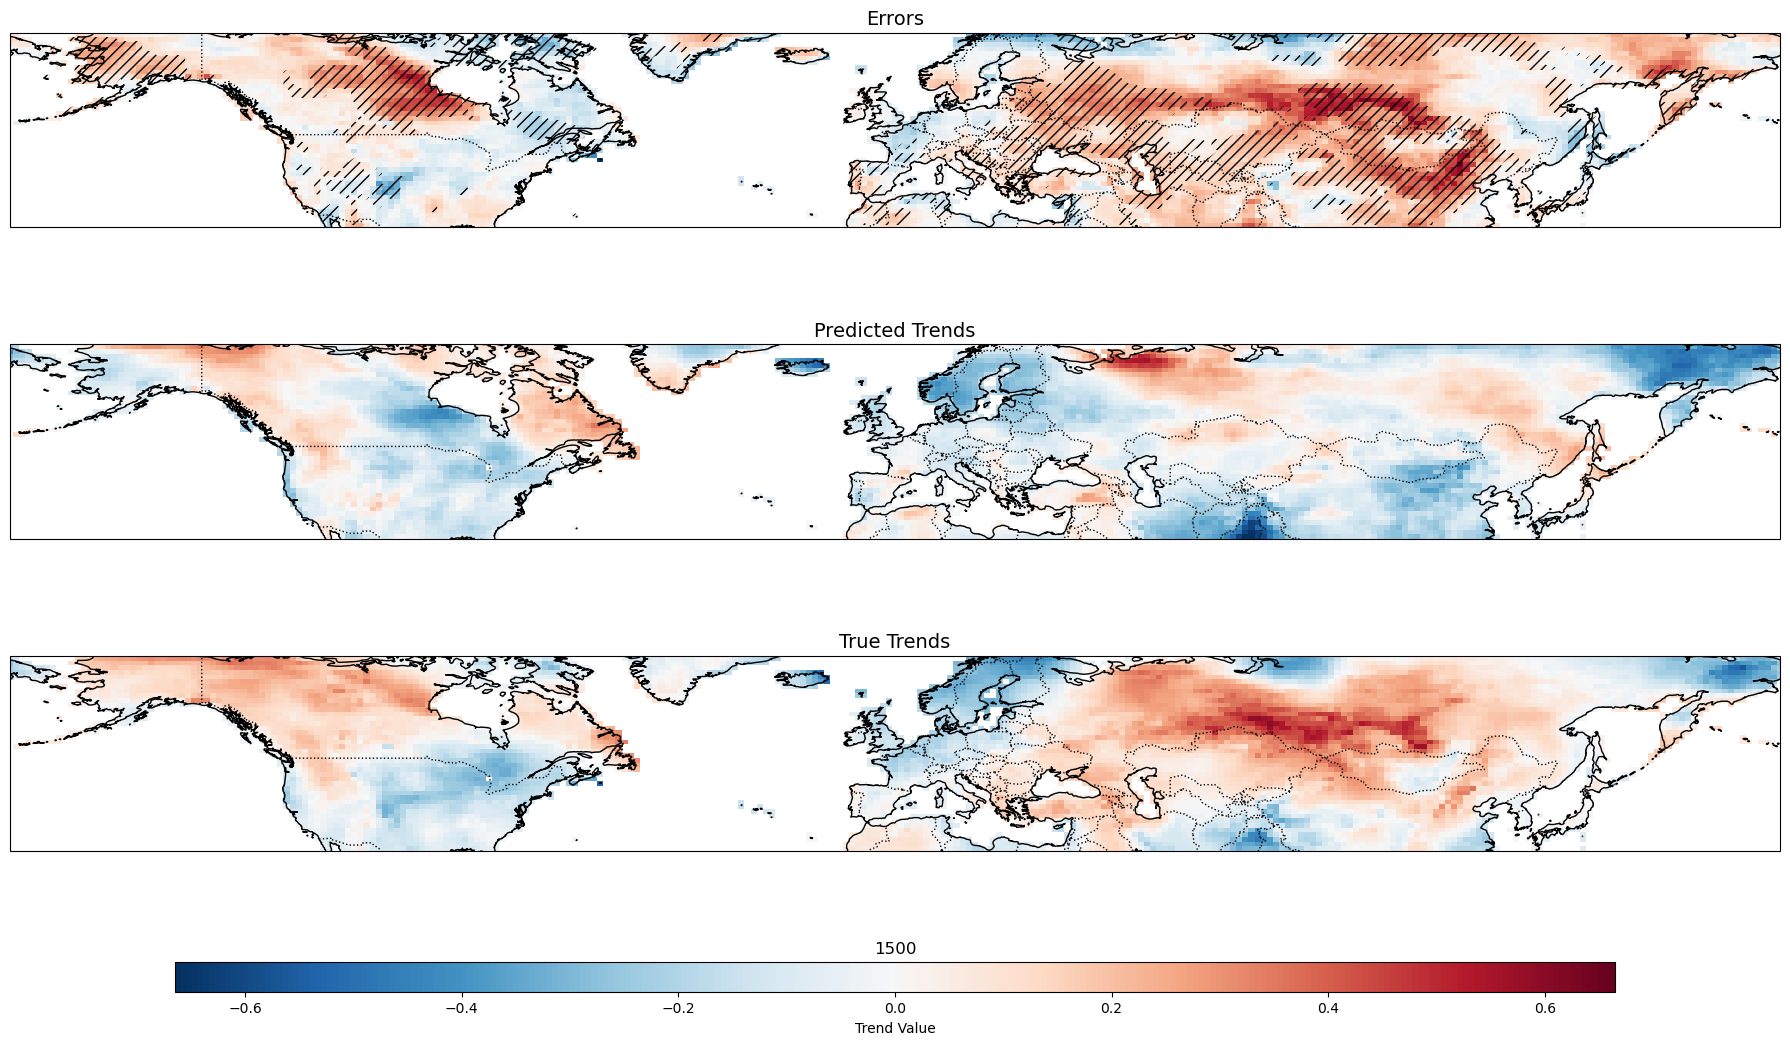

In [ ]:
plot_trends_on_world_map(trends_map_counterfactual - trends_map, trends_map, trends_map_counterfactual, sign_errors_map, lats, lons, land_sea_mask_recent.values, run)

In [ ]:
pd.DataFrame(np.array([trendsr2, trends_corr, correct_sign_ratio, ts_r2, ts_corr]).T, index=['Trends R2', 'Trends correlation', 'Correct trend sign', 'Time Serie R2', 'Time Serie Corrleation'], columns=[run +' (full)'])

,1500 (full)
Trends R2,0.047632
Trends correlation,0.511278
Correct trend sign,0.670552
Time Serie R2,0.855784
Time Serie Corrleation,0.929093
